<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference for 1D reaction-advection-diffusion problem

1. Finite Difference solver for the reaction-advection-diffusion problem:

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [4]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute rhs
  f = rhs(x[1:-1])
  
  # evaluate PDE coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)

  # compute diagonal entries
  diff_term =[-diff[1:], 2*diff, -diff[:-1]]
  conv_term = [-conv[1:], conv[0:-1]]

  # compute systmen matrix
  A =(1./h**2)*sp.diags(diff_term,[-1,0,1],format="csr") +(1./(2*h))*sp.diags(conv_term,[-1,1],format="csr")+ sp.diags(reac,0,format="csr")
  A=A[1:-1,1:-1]

  # apply boundary conditions

  return A,f,x

In [5]:
def FD1Dalt(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute rhs
  f = rhs(x)
  
  # evaluate PDE coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)

  # compute diagonal entries
  diff_term =[-diff[1:], 2*diff, -diff[:-1]]
  conv_term = [-conv[1:], conv[0:-1]]

  # compute systmen matrix
  A =(1./h**2)*sp.diags(diff_term,[-1,0,1],format="csr") +(1./(2*h))*sp.diags(conv_term,[-1,1],format="csr")+ sp.diags(reac,0,format="csr")

  # apply boundary conditions
  A[0,0]=1; A[0,1]=0; f[0]=0
  A[N,N]=1; A[N,N-1]; f[N]=0
  return A,f

Define FD problem and solve

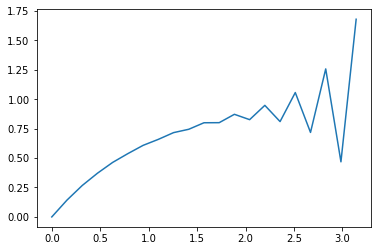

In [6]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 0.01 * np.ones(len(x))
beta = lambda x :  1. * np.ones(len(x))
gamma = lambda x : 1 * np.ones(len(x))
rhs = lambda x :   1 * np.ones(len(x))

# Grid
N=20
h = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)

# FD system
A, F = FD1Dalt(omega,N,alpha,beta,gamma,rhs)

# solve
Uh = sp.linalg.spsolve(A,F)

# insert boundary conditions
#Uh = np.insert(Uh,[0, N-1], [0., 0.])

# plot solution
plt.plot(x,Uh)

Repeat exercise with larger system including boundary conditions

Compute experimental order of convergence (EOC) using knowledge that 

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_2}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

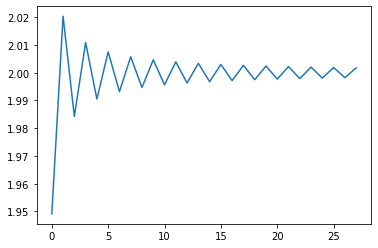

In [7]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 1. * np.ones(len(x))
beta = lambda x :  0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs =   lambda x : np.sin(x)
sol =   lambda x : np.sin(x)

# Fix number of experiments
no_experiments = 30
solutions=[]
error=[]
h=[]
for i in range(no_experiments-1):

# evaluate system for given N
  N = i*5+5
  h.append((omega[1]-omega[0])/N)
  A, F,x = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  U1 = sp.linalg.spsolve(A,F)
  solutions.append(U1)
  error.append(np.max(np.abs(U1-sol(x[1:-1]))))

  

plt.plot(range(no_experiments-2),(np.log(error[1:])-np.log(error[:-1]))/(np.log(h[1:])-np.log(h[:-1])))  



What if the exact solution is not known? Then we can still estiate the EOC but three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \approx C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

In [8]:
from functools import reduce
numbers = [1, 2, 3]
reduce((lambda x,y : x-y), numbers)

-4

[0.2715358021236134, 0.09188470451640329, 0.027741517327472653, 0.015842844143237222, 0.007278389249180783, 0.0025767818535116227, 0.0008786990942368789, 0.0005612628965504518, 0.0002510670947153404, 0.00012064334674910526, 4.908620672705588e-05, 1.8097979395004238e-05, 9.652329473475163e-06, 4.233731293989962e-06, 1.651091851462283e-06, 7.385625281353114e-07, 3.2182957254711653e-07, 1.6464458674203541e-07]


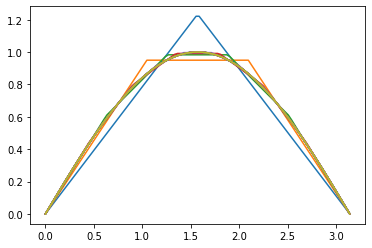

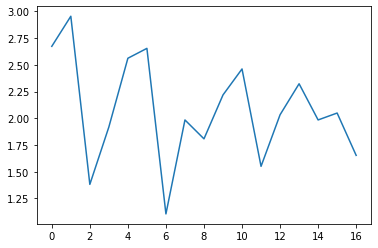

In [9]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 1. * np.ones(len(x))
beta = lambda x :  0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs =   lambda x : np.sin(x)
sol =   lambda x : np.sin(x)

# Fix number of experiments
no_experiments = 20
theta=1.5
solutions=[]
error=[]
h=[]

xtest=np.linspace(0,np.pi,100)
for i in range(no_experiments-1):

# evaluate system for given N
  N = int(theta**(i+2))
  h.append((omega[1]-omega[0])/N)
  A, F,x = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  U1=sp.linalg.spsolve(A,F)
  U1=np.concatenate([[0],U1,[0]],0)
  u_funct_vect=lambda t: np.interp(t,x,U1)
  plt.plot(xtest,u_funct_vect(xtest))
  
  solutions.append(u_funct_vect(xtest))
  
diff=[np.max(np.abs(solutions[i+1]-solutions[i])) for i in range(len(solutions)-1)]
print(diff)  
plt.show()
plt.plot(range(no_experiments-3),(np.log(np.array(diff[1:])/np.array(diff[:-1])))/-np.log(theta))  


**Exercise:** try this out for the problem with $f=1$.

[0.2741556778080374, 0.12893624604790166, 0.04589945893394676, 0.02496948322083714, 0.009407956000160977, 0.003840352727148777, 0.001872239570150147, 0.0007594340105507857, 0.00035349893911473806, 0.00014827240551684717, 7.112321151891976e-05, 2.913759991773901e-05]


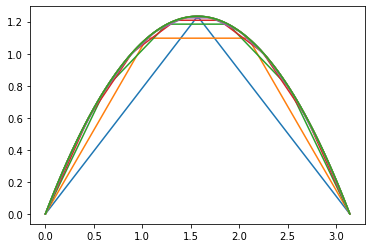

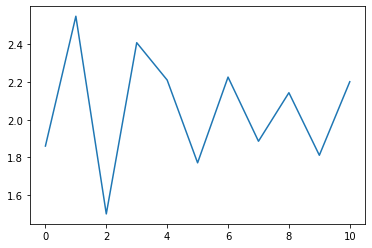

In [10]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 1. * np.ones(len(x))
beta = lambda x :  0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs =   lambda x : 1. * np.ones(len(x))
#sol =   lambda x : np.sin(x)

# Fix number of experiments
no_experiments = 14
theta=1.5
solutions=[]
error=[]
h=[]

xtest=np.linspace(0,np.pi,100)
for i in range(no_experiments-1):

# evaluate system for given N
  N = int(theta**(i+2))
  h.append((omega[1]-omega[0])/N)
  A, F,x = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  U1=sp.linalg.spsolve(A,F)
  U1=np.concatenate([[0],U1,[0]],0)
  u_funct_vect=lambda t: np.interp(t,x,U1)
  plt.plot(xtest,u_funct_vect(xtest))
  
  solutions.append(u_funct_vect(xtest))
  
diff=[np.max(np.abs(solutions[i+1]-solutions[i])) for i in range(len(solutions)-1)]
print(diff)  
plt.show()
plt.plot(range(no_experiments-3),(np.log(np.array(diff[1:])/np.array(diff[:-1])))/-np.log(theta))  

1. Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

Function computing the 1D FD algebric system

In [11]:
N=2
x = np.linspace(0,1,N+1)
y=x
xy=np.array([(i,j) for j in y for i in x]) 
print(xy)

[[0.  0. ]
 [0.5 0. ]
 [1.  0. ]
 [0.  0.5]
 [0.5 0.5]
 [1.  0.5]
 [0.  1. ]
 [0.5 1. ]
 [1.  1. ]]


In [59]:
def FD2D(omega,N,rhs):
  # FD system matrix and rhs in omega^2 for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format
  # with Nx = Ny = N

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  y = x
  xy=np.array([(i,j) for j in y for i in x]) #the array is ordered with x axis moving fast 
  # Compute rhs
  f = np.array([rhs(i[0],i[1]) for i in xy])

  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format



  


  # compute diagonal entries
  #diff_term =[-diff[1:], 2*diff, -diff[:-1]]
  #conv_term = [-conv[1:], conv[0:-1]]

  # compute systmen matrix
  A =(1./h**2)*sp.diags([1,1,-4,1,1],[-N-1,-1,0,1,N+1],shape=((N+1)**2,(N+1)**2),format="csr")

  # apply boundary conditions (homog Dirichlet)

  #boundary indices:
  bdd_ind=[]
  for i in range(len(xy)-1):
    if xy[i][0]==0 or xy[i][0]==1 or xy[i][1]==0 or xy[i][1]==1:
      bdd_ind.append(i)

  for j in bdd_ind:
    A[j,:]=np.zeros_like(A[j,:])
    A[j,j]=1
    f[j]=0 
  

  X=[i[0] for i in xy]
  Y=[i[1] for i in xy]

  return A,f,x,y
  

In [57]:
a=np.array([0,1,2,3])
a=np.reshape(a,(2,2))
print(a)

[[0 1]
 [2 3]]


Define FD problem and solve

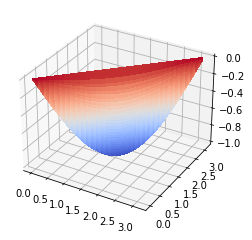

In [62]:
omega = [0,np.pi,0,np.pi]
N = 100
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
exact = lambda x, y : np.sin(x) * np.sin(y)

# call function computing FD system
A,f,X,Y= FD2D(omega,N,rhs)
#print(A.todense(),f)
# solve
U=sp.linalg.spsolve(A,f)
# plot solution
U=np.reshape(U,(N+1,N+1))
# Prepare data for plotting 

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, U, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()






**Exercise:** Compute error and EOC 

**Exercise:** Generalise to more general elliptic problems (PDE and boundary conditions)